1. more synchronization constrcuts+
1. hardware supported synchronization

1. May repeatedly check to continue
    1. sync with spinlocks
1. may wait for a signal to continue
    1. sync with mutexes and condition variables
1. waiting hurts performance
    1. CPUs waste cycles for checking, cache effects

### More about synchronization
1. Mutexes
1. Condition variable
1. why more
    1. limitation of mutexes and condition variables
        1. error prone/corretness/ease-of-use
            1. unlock wrong mutex
            1. signal wrong condition variable
        1. lack of expressive power
            1. helper varaibels for access or priority control
    1. requires lower level support 
        1. hardware atomic instructions

### Spinlocks (basic sync construct)
1. spinlock is like a mutex
    1. mutual exclusion
    1. lock and unlock (free)
1. but 
    1. if lock is busy, the process spin on execution instead of being block (repeatedly checking)

In [ ]:
spinlock_lock(s);
    //critical section
spinlock_unlock(s);

### Semaphores (designed by E.W. Dijkstra)
1. common sync construct in OS kernels
1. like a traffice light: stop & go
1. simllar to a mutex but more general
1. an integer value
    1. on init: assigned a max value (positve int) => maximum count
    1. on try(wait): (P, proberen)
         1. if non-zero=>decreament and proceed => counting semaphore
         1. 0 => wait
    1. if initializeed with 1
        1. semaphore == mutex (binary semaphore)
    1. on exit (post): (V, verhogen) increment the counter
         

In [ ]:
//POSIX semaphore API
#include <semaphore.h>
sem_t sem;
sem_int(sem_t *sem, init pshared, int count); //pshared shared among processed
sem_wait(sem_t *sem);
sem_post (sem_t *sem);

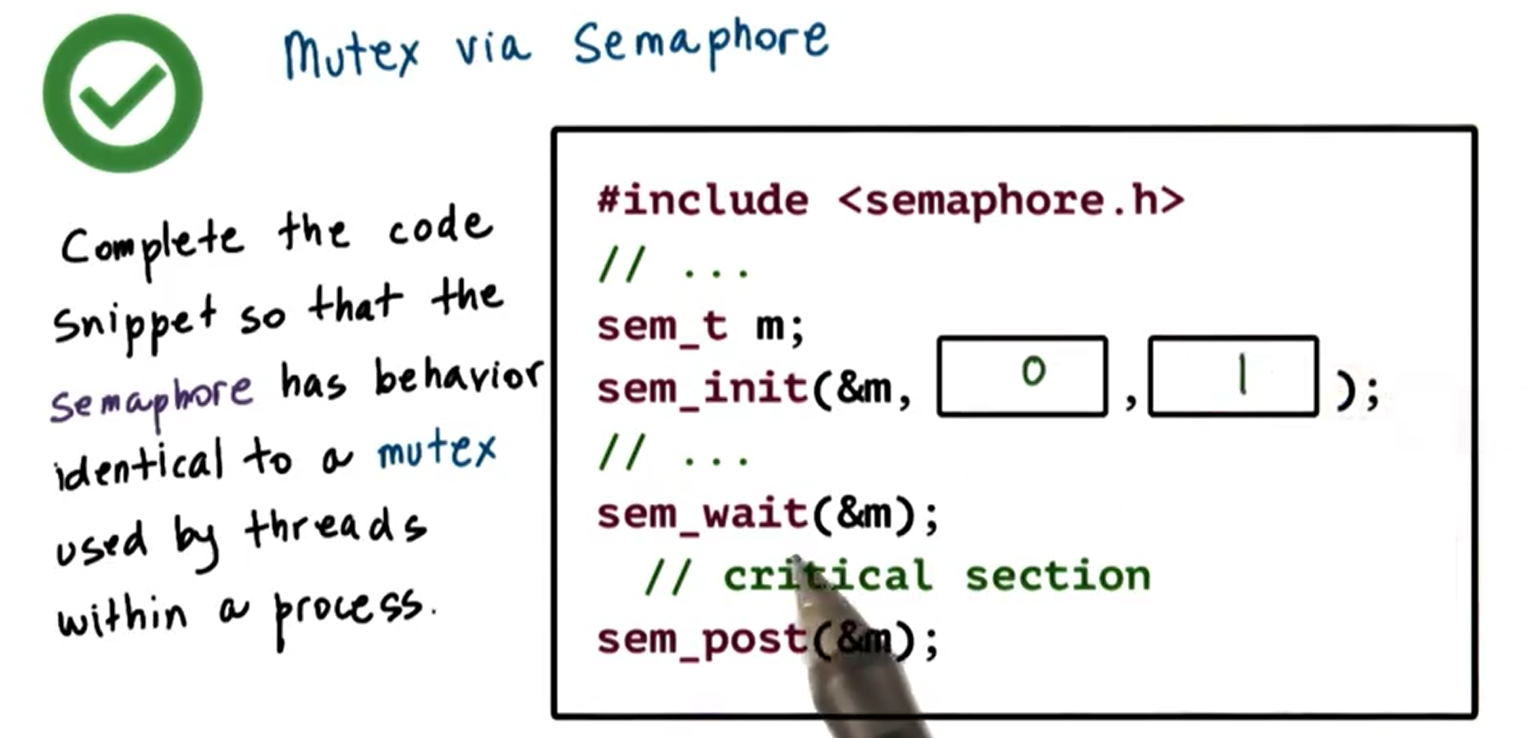

### Reader/Writer locks

Syncing different types of accesses
1. read (never modify): shared access
1. write (always modify): exclusive access


RW lock:
1. specify the type of access
1. then lock behaves accordingly


In [ ]:
#include <linux/spinlock.h>

rwlock_t m;
read_lock(m);
// Critical section
read_unlock(m);

write_lock(m);
// Critical section
write_unlock(m);

### Using RW locks
1. supported in Windows(.NET), Java, POSIX...
1. read/write == shared/exclusive

Semantic differences
1. recursive read_lock => what happends on read_unlock? one or all?
1. upgrade/downgrade priority?
1. Interaction with scheduling policy
    1. e.g. block if higher priority writer waiting

### Monitors
1. higher level synchronization construction 
1. not need to lock/unlock
1. specify
    1. shared resource
    1. entry procedure
    1. possible condition variables
1. on entry
    1. lock, check
1. on exit
    1. unlock, check, signal
1. historically included in the MESA language runtime by XEROX PARC
1. Java
    1. synchronizaed methods generate monitor code
    1. notify() explicitly
1. monitors == programming style
    1.enter_/exit_critical section in threads and concurrency lesson

### More synchronization Constructs
1. Serializers: easier to define priorities
1. path expressions
1. barriers: block until n threads arrive
1. rendezvous points: wait for multiple thread
1. optimistic wait-free sync(RCV)
1. they all need hardware support

### Spinlocks revisited
1. Spinlock => basic sync construct
    1. "The performance of spinlock alternative for shared memory muliprocessors" by Anderson
        1. alternative implementations of spinlocks
        1. generalize thechques to other constructs

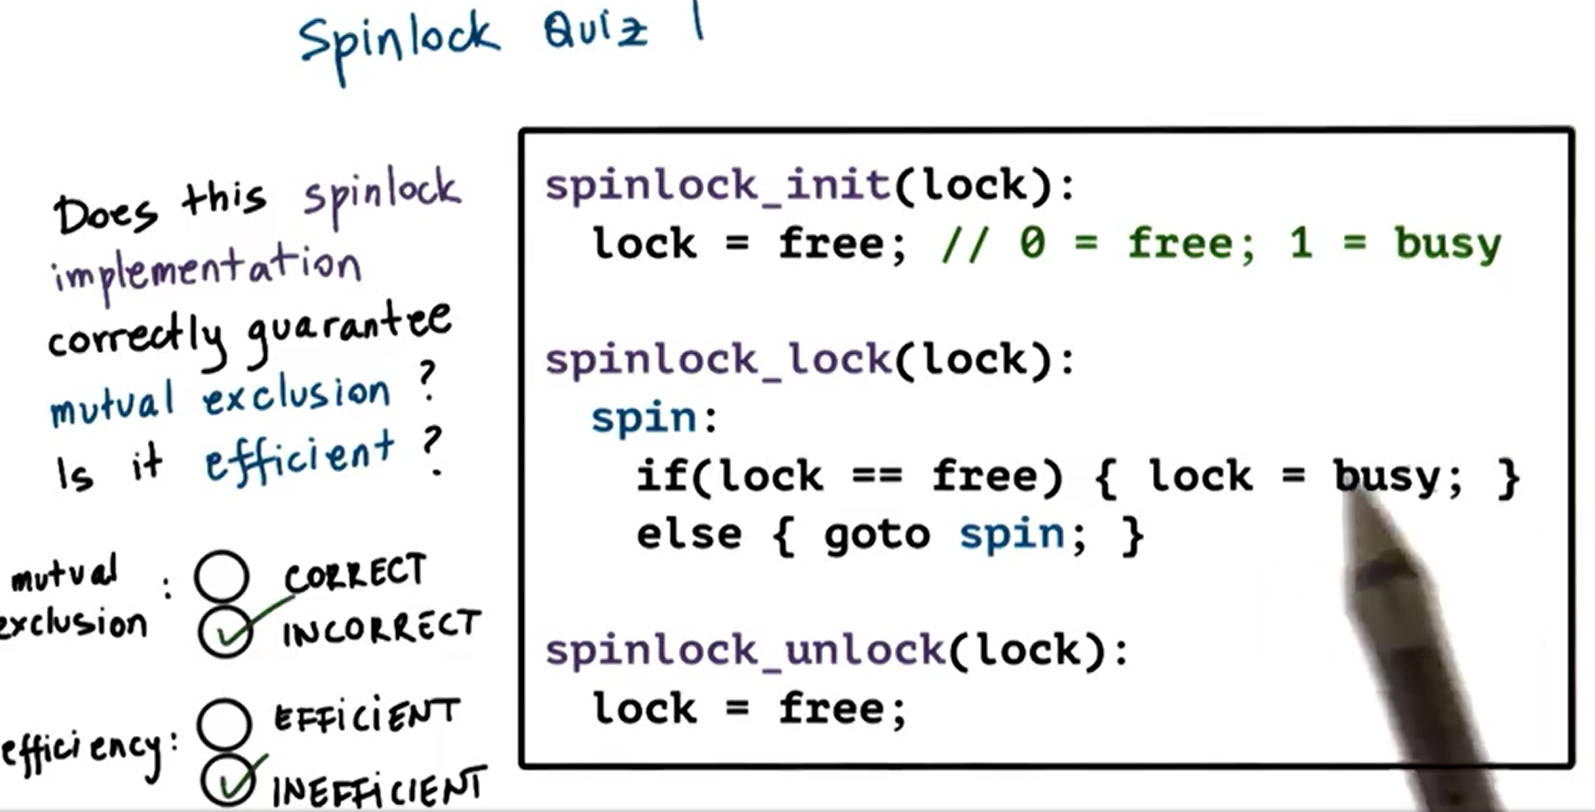


### Need for hardware Support
1. Problem: 
    1. concurrent check/update on different CPUs can overlap
1. hardware-supported atomic instructions

### Atomic Instructions
1.Hardware specific
    1. test_and_set
    1. read_and_increament
    1. compare_and_swap
1. Guarantees
    1. atomicity
    1. mutual exclusive 
    1. queue all concurrent instructions but one
1. atomic instructions=>critical section with hardware-supported synchronization

In [ ]:
spinlock_lock(lock) {
    while (test_and_set(lock) == busy);
}

1. atomically returns (tests) original value and sets new value = 1 (busy)
    1. first thread: 0: free
    1. second thread: 1: busy
1. different hardware have difrerent atomic instructions

### Shared Memory Multiprocessors (memory accessible to all CPUs)
1. bus-based
    1. the shared bus only one memoery reference at a time can be in flight (bus is shared across all the modules
1. interconnect(I/C) based
    1. it can have multi memoery reference in flight, where one memory refernce is applied to one memeory module and another one to the other memeory module
1. also called symmetric multiprocessors (SMP) 
1. each of the CPUs can have caches
1. access to the cached data is faster so cachees are useful to hide the memory latency
1. the memory latency is even more of an issue in sahred memoery systems
    1. contention on the memory module
    1. certain memoery reference have to be delayed
    1. add to the memory latency even more 
1. when CPU perform write
    1. you may not even allow a write to happen to the cache
        1. a write diretly go to memory
        1. any cached copy of that particular memory location will be invalidated
    1. write through: CPU write may be applied both to the cached location and directly in memory
    1. write back: write can be applied in cache, the actual update to the memory location can be delayed and applied later (when that cache line is evicted)

### Cache Coherence
1. what happen if multi CPUs refernce the same data x
1. x in multi caches
1. non-cache-coherent (NCC) architecture: need to be fixed in software
    1. if one cpu modifies x, but others don't 
1. cache-coherent platforms: hardware take care of all the necessary steps to make sure that the caches are coherent
    1. hardware make sure that the cache on the other CPU is also updated
1. basic methods used in cache coherence:
    1. write-invalidate (NCC)
        1. if other cpu cache the modifed data, it will be invalidated
        1. future references on this CPU to x will result in a cache miss and be pushed over to memory
        1. memory has been updated with write-back/write-through
        1. lower bandwidth amortize costs (lower bandwidth requriement due to the delay sending the full value/ just send the address so it can be invalidated in other caches)
        1. once cache is invalidated, future modifications to the same memory location will not results in subsequent invalidations
        1. if not needed on other CPUs soon, it's possible to amortize the cost of the coherence traffic over multiple changes
    1. write-update (CC)
        1. hardware make sure if other cache has cached the same memory location, its value gets updated
        1. access will result in a cache hit and return the correct value
        1. update avaible immediately: not to pay the cost to perform another memory access
        1. good for program need to access teh value of x immediately after it's updated on another CPU
1. programmer don't have choice, it's a property of the hardware architecture 

### Cache Coherence and Atomics
1. situation
    1. 2 CPUs
    1. both need to perform some atomic instruction involve the memory location of x
    1. x is cached in both CPU
1. how to prevent multiple threads on different CPUs
1. if we allow atomic constructions to read and update cached value there will be problems
    1. multi cpu with caches, we don't know where that value has been cached
    1. write-update vs write invalidate protocols
    1. latency on the chip
    1. challenge if a particular atomic is applied to the cache on one CPU to know whether on another CPU another atomic instruction is attempted against teh cached value in that CPU
1. for the reasons above, atomic operations bypass the caches
    1. always directly access teh memory location
    1. pros:
        1. can be ordered synchronized
        1. no race condition can occure
    1. cons:
        1. take much longer than other types of instructions
        1. always access memory
        1. always content on memory
    1. guarantee atomic behavior
        1. have to generate the coherence traffic 
            1. either update 
            1. or invalid all ofthe cached copies of this memory reference (even if the value doesn't change, stay on the side fo safety and to guarantee correctness of the atomic operations)
1. Atomics & SMP are more expensive compared to on a single CPU system due to 
    1. bus or I/C contention
    1. cache by pass & coherence traffice

### Spinlock Performance Metrics
1. reduce latency
    1. time  to acqurie a free lock
    1. ideally immediately execute atomic
1. Reduce waiting time (delay)
    1. time to stop spining and acquire a lock that has been freed
    1. ideally immediately
1. reduce contention
    1. bus/network I/C traffic
    1. ideally zero
    1. may delay unlock (slow down lock owner's work)

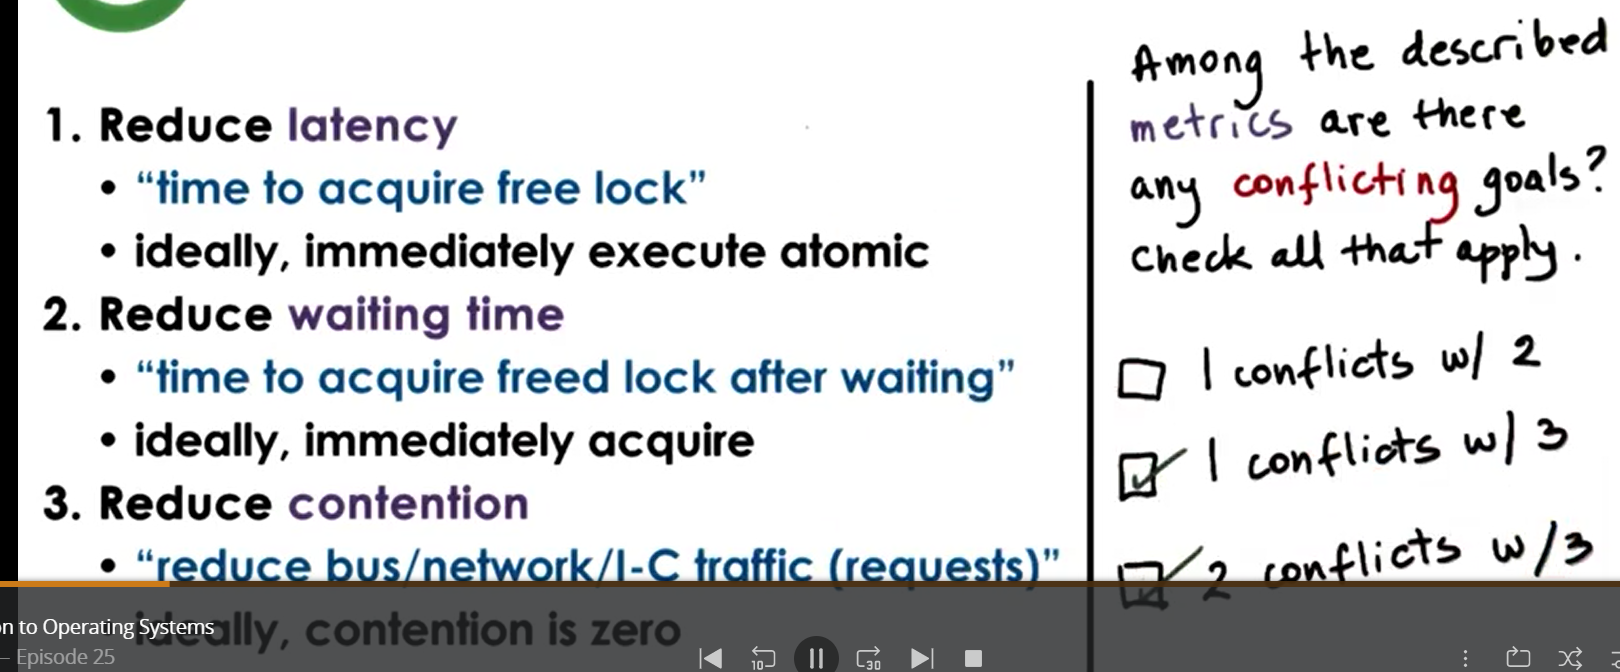

In [ ]:
//Test-and-set-Sprinloc

spinlock_init(lock) {
    lock = free;
}

spinlock_lock(lock) {
    while (test_and_set(lock)==busy);
}

spinlock_unlock(lock) {
    lock = free;
}

1. Latency
    1. minimal (just atomic) 
1. Delay
    1. potentially minimal (spinning continously on the atomic)
1. contention
    1. processors go to memory on each spin
1. problem:
    1. Spining on atomic instruction: go to memory

In [ ]:
//Test_and_test-and-set-Sprinloc
//spin on read
//spin on cached value
spinlock_init(lock) {
    lock = free;
}

spinlock_lock(lock) {
    while ((lock==busy) OR test_and_set(lock) == busy);
}

spinlock_unlock(lock) {
    lock = free;
}

1. Latency
    1. OK
1. Delay
    1. OK
1. contention
    1. better but not ok
    1. if ncc: no difference
    1. if cc-wv: ok
    1. if cc-wt: horrible
1. problem:
    1. if we don't have a cache conherent architecture, then every singel memory reference will go to memory just like  with test_and_set so there is no difference
    1. cc-wv (value-update) - ok. 
        1. One problem is that all of the processors with right update will see that the lock becomes free.
        1. regarding the delay, every single one of them will at the same time try to execute the test_and_set operation which can potentially be an issue
        1. if the lock was busy before the write update event and remain busy after the right update event => no change. that particular cpu can continue spinning from teh the cached copy
    1. cc-wt (invalidate based architecture) - horrible
        1. every single attempt to acquire the lock not only that it will generate contention for the memory module
        1. also create invalidation traffic
        1. one outcome of executing an atomic instrution is that we will trigger the cache coherence, so the right update or right invalidate traffic are regardless of what the situation is 
        1. we simply invalidate the cached copy, so it's possible that the lock was busy before the cache coherence event 
        1. if the atomic instruction was not successful, the lock is still busy.
        1. as far as the caches in the sytem are concerned, that atomic instruction invalidated their cache copy of the lock
        1. they will have to go out to memory to fetch this copy of lock
        1. every time someone perform the atomic instruction
        1. this type of behavior compound the contention effects and make performance worse
        1. at the same time, everybody will se the lock has changed its state
        1. everyone will at the same time try to acquire this lock


1. all the caches will be invalidated after that initial lock release
1. for some processors, by the time they reread the lock value from memory in order to execute his part of the predicte, the lock will already have been set to busy by another processor.
1. those processors will try to spin on the newly read cached copy
1. other processors when they reread the value of lock from memory that will happen before any test_and_set has executed, so they will see the value of lock is free, they will try to execute that test_and_set operation 
1. only one will succeed, but every single one of them will go ahead and invalidate everybody's caches

### Spinlock "delay" alternatives
Delay after lock release
1. everyone sees lock is free
1. not everyone attempts to acquire it
1. pros: 
    1. contention improved: 
        1. the delayed thread will try to recheck the value of the lock. it's possible that somebody else has set the lock to busy
        1. if the lock is free it will execute the atomic operation, with the delay it's likely not all threads will execute the atomic operation at the same time, and the thread will not repeatedly invalid cached value
    1. Latency: OK
    1. Delay: much worse: we have to delay



In [ ]:
spinlock_lock(lock) {
    while((lock == busy) OR (test_and_set(lock) == busy)) {
        // failed to get lock
        while (lock == busy) {
            // spin
        }
        delay();
    }
}

Delay after each lock reference
1. doesn'tspin constantmly
1. works on ncc architectures (delay help mitigate the memory contention)
1. but can hurt delay even more (build up delay even when there is no contention on the network)

In [ ]:
spinlock_lock(lock) {
    while((lock == busy) OR (test_and_set(lock) == busy)) {
        delay();
    }
}

### Picking a Delay (for a delay spinlock)
1. static delay (based on fixed value, e.g. CPU id) 
    1. to determine a delay for any single process on the CPU
    1. simple approach
    1. under high load this delay will nicely spread out all of the atomic references so there is not contention
    1. the delay will have to be a combination of something that combines this fixed information and the length of the critical section
    1. so that one process is delayed one times the critical section and another process is delayed twice the  critical section and so forth 
    1. create unnecessary delay under low contention
1. dynamic delay (backoff-based)
    1. each process will pick a randome delay
    1. random delay in a range that increases with perceived contention
    1. when system is operating in a mode of low contention, it will choose dynamic delay value within a smaller range (delay for a little bit)
    1. when the system is operating in a mode of large contention, then the delay range will be much larger => some processes will be delayed for quite a bit of time
1. both will result in the same behavior under high load
1. how much contention?
    1. perceived == failed test_and_set()
    1. problem:
        1. if we delay after every single lock  reference will keep growing 
            1. if there is indeed contention in the system or 
            1. the owner of the criticcal section is delayed or it's executing a long critical section (don't need to bump up the delay)

### Queuing Lock
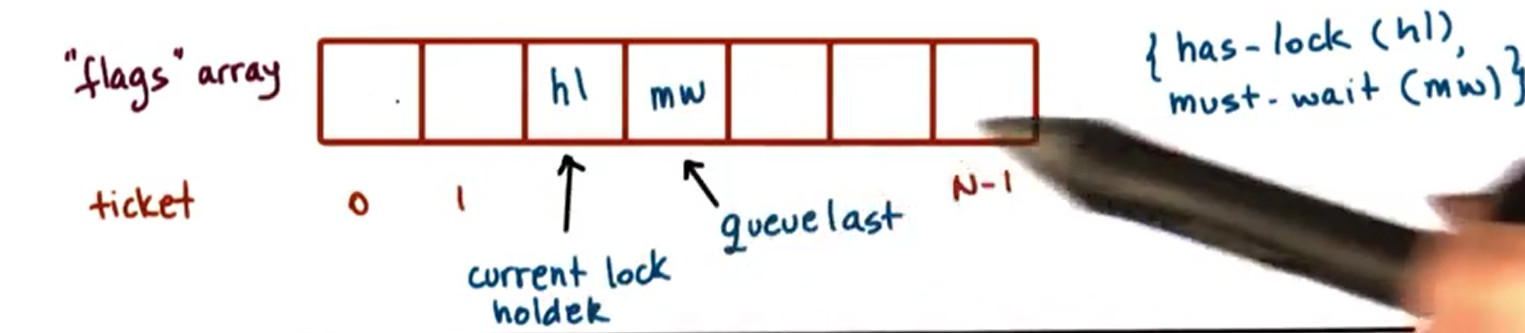
Common problem in spinlock implementation
1. everyone tries to acquire a lock at the same time once lock is freed (delay alternative)
1. everyone sees the lock is free at the same time (anderson's queueing lock)
1. queuing lock
    1. uses an array of flags
    1. with up to N elements where N is the number of processors in the system 
    1. every single one of the elements will ahve one of the two values
        1. has-lock
        1. must-wait
    1. two prointers
        1. the current lock holder
        1. index into this array that has the last element on the queue 
    1. when a new thread arrives at the lock, it will get a ticket that will be the current position on the thrad in the lock
    1. done by adding it after the existing last element in the queue
    1. the queue last value will be incremented
    1. the new thread will be asigned the next position in the array
    1. multi threads may be arriving at the lock at the same time, queue incrementation is done atomically
    1. queuing lock depends on support for ann atomic read_and_increment (not as commen as test_and_set)
    1. for each thread arriving at the queuing spinlock, the assigned element of this flags array, the queue ticket, acts like a private lock
        1. must-wait => spin: as long as the value of the queue ticket is must-wait, the thread will ahve to spin just like with a spinlock
        1. has_lock => enter critical section: when the value of this element becomes has-lock, it's an indication that the lock is free and you can go ahead and proceed
        1. signal/set next lock holder on exit => queue[ticket+1] = has_lock: when a thread completes the critical section and needs to release the lock, it signals the next flag in the queuing array.
    1. downsize:
        1. assumes read_and_increment atomic
        1. O(N) size, much larger than other spinlock implementations which only need O(1) for the lock
        

In [ ]:
//Queuing lock/Anderson lock implementation
init:
    flag[0] = has-lock;
    flag[1..p-1] = must-wait;
    queuelast = 0; //global variable
    
lock:
    myplace = r&inc(queuelast); //get ticket, read_and_increment
    while(flags[myplace mod p] == must_wait) ;
    // now in critical section
    flags[myplace mod p] = must_wait;

unlock:
    flag[myplace+1 mod p] = has-lock;

1. Latency: more costly r&inc: 
    1. read_and_increment is more costly than read_and_set
    1. need to perform mod in the index array
1. Delay: good
    1. directly signal next CPU/thread to run
1. Contention: better, but 
    1. requires cache coherence: otherwise the spinning has to happen on potentially remote memory reference
    1. cacheline alligned elements: every element is in a separate cache line, otherwise when we change the value of one element of the array we will invalidate the entire cache line and potentially the caches of the other elements in the array
1. Only 1 CPU/thread sees the lock is free and tries to acquire the lock

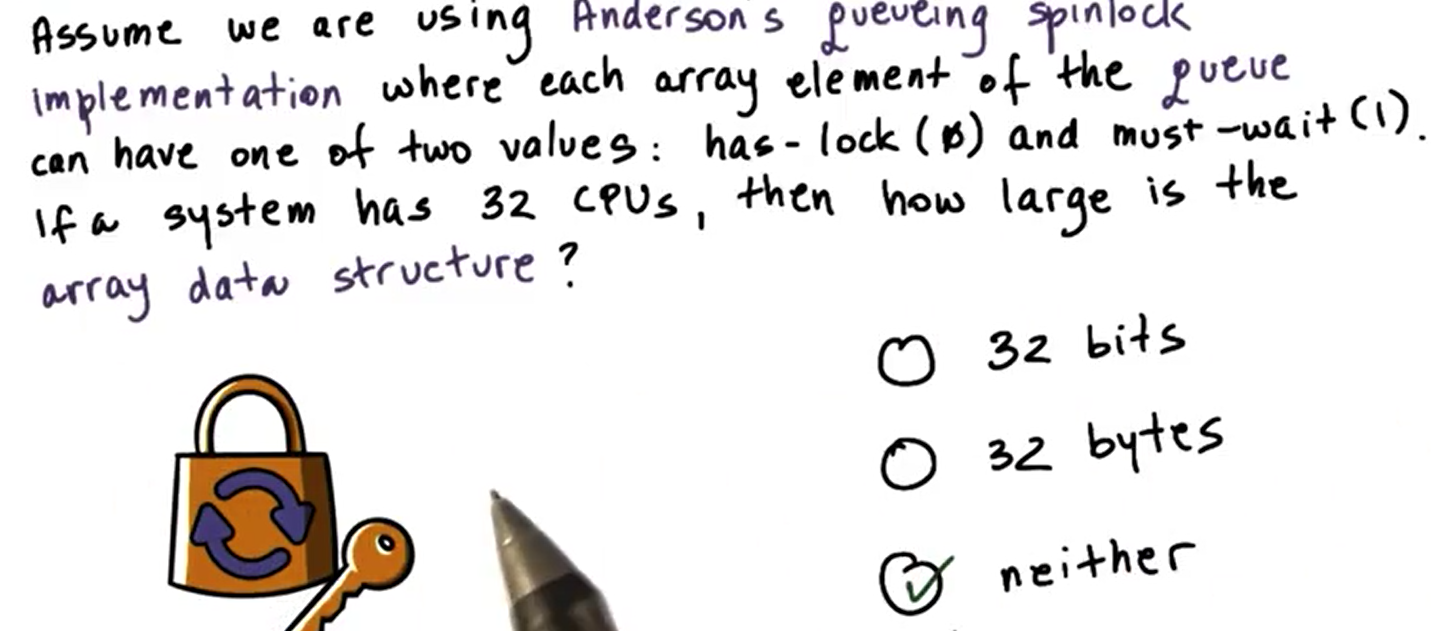
each of the element array has to be in a different cacheline, so the size of datastructure depends on the size of cacheline
1. cacheline size * number of cpu

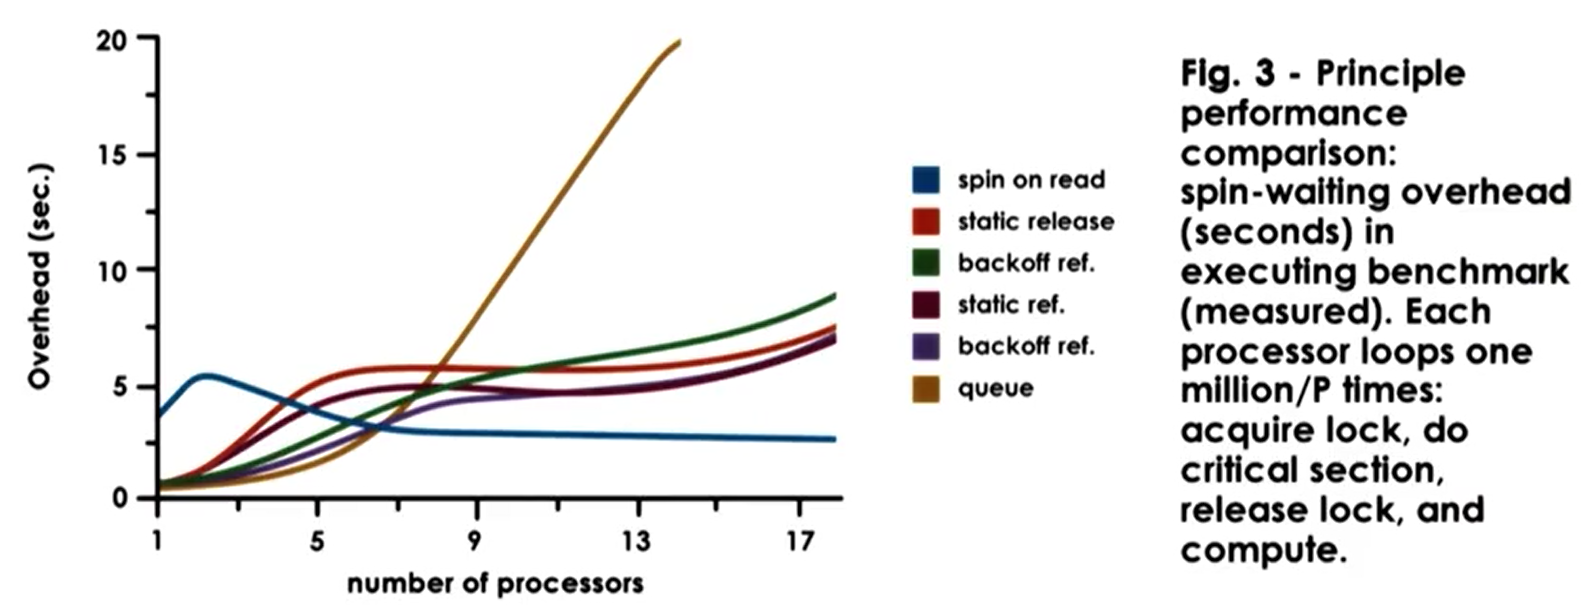
Setup
1. N processores running CS/M times
1. N varied based on system

Metrics
1. overhead compared to ideal performance (how long it takes to execute that fixed number of critical section without contention, no lock)
    1. theoretical limit based on # of CS to be run


Under high loads
1. queue best (most scalable),
1. test_and_test_and_set worst
1. simple test_and_set not included, would off the chart
1. static better than dynamic
1. reference better than release ( avoid extra invalidation)
    
under light loads
1. test_and_test_and_set good (low latency)
1. dynamic better than static (low delay)
1. queuing lock worst (high latency due to read_and_increment)


No single good answer, should be based on expected workload